In [59]:
%matplotlib inline
morange = u'#ff7f0e'
mblue = u'#1f77b4'
mgreen = u'#2ca02c'
mred = u'#d62728'
mpurple = u'#9467bd'
from matplotlib import pyplot as plt
import numpy as np 
import h5py


In [60]:
from astropy.table import Table
mock = Table()

import os
csdir = "/global/projecta/projectdirs/lsst/groups/CS/cosmoDC2"
dirname = os.path.join(csdir, "cosmoDC2_v1.0.0")
basename = "z_0_1.step_all.healpix_564.hdf5"

with h5py.File(os.path.join(dirname, basename)) as f:
    mock['redshift'] = f['galaxyProperties/redshift'].value
    mock['mstar'] = f['galaxyProperties/totalMassStellar'].value

    keys_to_keep = list(
        key for key in f['galaxyProperties/LSST_filters'].keys() 
        if 'observed:dustAtlas' in key and 'magnitude' not in key)
    keys_to_keep2 = list(key for key in f['galaxyProperties/otherLuminosities'].keys() 
                            if 'Lyc' not in key)
    for key in keys_to_keep:
        mock[key] = f['galaxyProperties/LSST_filters'+'/'+key].value
    for key in keys_to_keep2:
        mock[key] = f['galaxyProperties/otherLuminosities'+'/'+key].value

for key in mock.keys():
    newkey = key.replace(':LSST', '')
    newkey = newkey.replace('LuminositiesStellar', '')
    newkey = newkey.replace('observed:dustAtlas', '')
    newkey = newkey.replace('spheroid', 'bulge')
    newkey = newkey.replace(':B:', '_B_')
    newkey = newkey.replace(':V:', '_V_')
    newkey = newkey.replace('rest:dustAtlas', 'rest_dust')
    newkey = newkey.replace(':', '')
    mock.rename_column(key, newkey)
print(mock.keys())

['redshift', 'mstar', 'disk_g', 'disk_i', 'disk_r', 'disk_u', 'disk_y', 'disk_z', 'bulge_g', 'bulge_i', 'bulge_r', 'bulge_u', 'bulge_y', 'bulge_z', 'total_g', 'total_i', 'total_r', 'total_u', 'total_y', 'total_z', 'disk_B_rest', 'disk_B_rest_dust', 'disk_V_rest', 'disk_V_rest_dust', 'bulge_B_rest', 'bulge_B_rest_dust', 'bulge_V_rest', 'bulge_V_rest_dust', 'total_B_rest', 'total_B_rest_dust', 'total_V_rest', 'total_V_rest_dust']


In [61]:
def _calc_Rv(lum_v, lum_v_dust, lum_b, lum_b_dust): #Rv definition with best behavior
    with np.errstate(divide='ignore', invalid='ignore'):
        Av = -2.5*np.log10(lum_v_dust) + 2.5*np.log10(lum_v)
        Ab = -2.5*np.log10(lum_b_dust) + 2.5*np.log10(lum_b)
        Ebv = -2.5*np.log10(lum_b_dust) + 2.5*np.log10(lum_b) - 2.5*np.log10(lum_v_dust) + 2.5*np.log10(lum_v)
        Rv = Av / Ebv
        Rv[(Av == 0) & (Ab == 0)] = 1.0
        #remove remaining nans and infs for image sims
        mask = np.isfinite(Rv)
        r = np.random.RandomState(43) # for reproduceability
        Rv[~mask] = r.uniform(1.0, 5.0, np.count_nonzero(~mask))
        return Rv


def _calc_Av(lum_v, lum_v_dust):
    with np.errstate(divide='ignore', invalid='ignore'):
        Av = -2.5*(np.log10(lum_v_dust/lum_v))
        Av[(lum_v==0) & (lum_v_dust==0)] = 0     
        return Av

mock['total_Rv'] = _calc_Rv(mock['total_V_rest'], mock['total_V_rest_dust'],
             mock['total_B_rest'], mock['total_B_rest_dust'])
mock['bulge_Rv'] = _calc_Rv(mock['bulge_V_rest'], mock['bulge_V_rest_dust'],
                 mock['bulge_B_rest'], mock['bulge_B_rest_dust'])
mock['disk_Rv'] = _calc_Rv(mock['disk_V_rest'], mock['disk_V_rest_dust'],
                 mock['disk_B_rest'], mock['disk_B_rest_dust'])
mock['total_Av'] = _calc_Av(mock['total_V_rest'], mock['total_V_rest_dust'])
mock['disk_Av'] = _calc_Av(mock['disk_V_rest'], mock['disk_V_rest_dust'])
mock['bulge_Av'] = _calc_Av(mock['bulge_V_rest'], mock['bulge_V_rest_dust'])


In [62]:
np.count_nonzero(mock['bulge_V_rest'] == mock['bulge_V_rest_dust']), len(mock['bulge_V_rest'])

(18986309, 31905158)

In [63]:
mask_Av1 = mock['total_Av']<0
mask_Avd1 = mock['disk_Av']<0
mask_Avb1 = mock['bulge_Av']<0
print(np.min(mock['total_Av']), np.count_nonzero(mask_Av1)/float(len(mock['bulge_V_rest'])))
print(np.min(mock['bulge_Av']), np.count_nonzero(mask_Avb1)/float(len(mock['bulge_V_rest'])))
print(np.min(mock['disk_Av']), np.count_nonzero(mask_Avd1)/float(len(mock['bulge_V_rest'])))

-0.0194128 0.15160880883272856
0.0 0.0
-0.0214153 0.19388024970758647


In [64]:
z0, z1, z2, z3 = 0.35, 0.6, 0.8, 1.1
z0_mask = mock['redshift'] < z0
z1_mask = (mock['redshift'] >= z0) & (mock['redshift'] < z1)
z2_mask = (mock['redshift'] >= z1) & (mock['redshift'] < z2)
z3_mask = (mock['redshift'] >= z2) & (mock['redshift'] < z3)


In [84]:
mask_Rv1 = mock['total_Rv']<0.1
mask_Rvd1 = mock['disk_Rv']<0.1
mask_Rvb1 = mock['bulge_Rv']<0.1
print(np.min(mock['total_Rv']), np.count_nonzero(mask_Rv1)/float(len(mock['bulge_V_rest'])))
print(np.min(mock['bulge_Rv']), np.count_nonzero(mask_Rvb1)/float(len(mock['bulge_V_rest'])))
print(np.min(mock['disk_Rv']), np.count_nonzero(mask_Rvd1)/float(len(mock['bulge_V_rest'])))

-5801.0 0.1284641812461797
0.0 0.06457516994587521
-3430.0 0.132520735361975


In [160]:
mask_Av2 = mock['total_Av']>1.
mask_Avd2 = mock['disk_Av']>1.
mask_Avb2 = mock['bulge_Av']>1.

print(np.count_nonzero(mask_Av2 & mask_Rv1 )/float(len(mock['bulge_V_rest'])))
print(np.count_nonzero(mask_Avb2 & mask_Rvb1)/float(len(mock['bulge_V_rest'])))
print(np.count_nonzero(mask_Avd2 & mask_Rvd1)/float(len(mock['bulge_V_rest'])))
print(len(mock['disk_V_rest'][mask_Avd2 & mask_Rvd1]))
print(mock['disk_V_rest'][mask_Avd2 & mask_Rvd1], mock['disk_V_rest_dust'][mask_Avd2 & mask_Rvd1])

0.0
0.0
2.5074315569915057e-07
8
disk_V_rest
-----------
4.64383e+08
4.86303e+08
 4.9931e+08
5.00113e+08
4.84176e+08
4.79527e+08
3.98455e+07
1.42568e+07 disk_V_rest_dust
----------------
     3.18095e-43
     7.48293e-43
     8.07148e-43
     1.00473e-42
     8.82818e-43
      1.1911e-42
     2.26193e-40
     8.40779e-45


In [89]:
mask_Rv2 = (mock['total_Rv']>=0.1) & (mock['total_Rv'] <= 1.)
mask_Rvd2 = (mock['disk_Rv']>=0.1) & (mock['disk_Rv'] <= 1.)
mask_Rvb2 = (mock['bulge_Rv']>=0.1) & (mock['bulge_Rv'] <= 1.)
print(np.count_nonzero(mask_Av2 & mask_Rv2)/float(len(mock['bulge_V_rest'])))
print(np.count_nonzero(mask_Avb2 & mask_Rvb2)/float(len(mock['bulge_V_rest'])))
print(np.count_nonzero(mask_Avd2 & mask_Rvd2)/float(len(mock['bulge_V_rest'])))

0.011300085083421308
0.004356411587117043
0.012883465425872518


disk_Av 6185780 0.19388024970758647
-0.0214153
bulge_Av 0 0.0


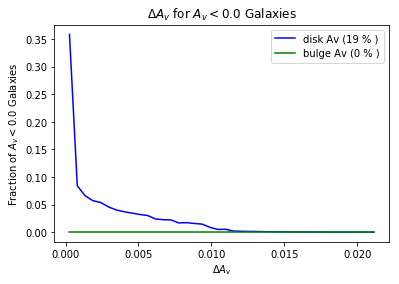

In [83]:
from scipy.stats import binned_statistic
import re
fig, ax = plt.subplots(1, 1)
Av_new = 0.
masks = [mask_Avd1, mask_Avb1]
quantities = ['disk_Av', 'bulge_Av']
colors = ['blue', 'green']
for msk, q, c in zip(masks, quantities, colors):
    total = np.count_nonzero(msk)/float(len(mock['bulge_V_rest']))
    print(q, np.count_nonzero(msk), np.count_nonzero(msk)/float(len(mock['bulge_V_rest'])))
    label = re.sub('_', ' ',q) + ' ({:.0f} % )'.format(100.*total)
    if np.count_nonzero(msk) > 0:
        print('min =',np.min(mock[q][msk]))
        N, bins = np.histogram(Av_new - mock[q][msk], bins=40)
        bin_cent = 0.5*(bins[:-1] + bins[1:])
        __=ax.plot(bin_cent, N/float(np.count_nonzero(msk)), color=c, label=label)
    else:
        __=ax.plot(bin_cent, np.zeros(len(bin_cent)), color=c, label=label)

leg = ax.legend()
xlabel = ax.set_xlabel(r'${\Delta A_{\rm v}}$')
cut = '$A_v < {:.1f}$ Galaxies'.format(Av_new)
ylabel = ax.set_ylabel('Fraction of {}'.format(cut))
title = ax.set_title(r'$\Delta A_v$ for ' + cut)
figname = 'av_shift.png'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')       


disk_Rv 4228095 0.132520735361975
min/max = 1.19358e-05 3430.1
bulge_Rv 2060281 0.06457516994587521
min/max = 5.7146e-06 0.1


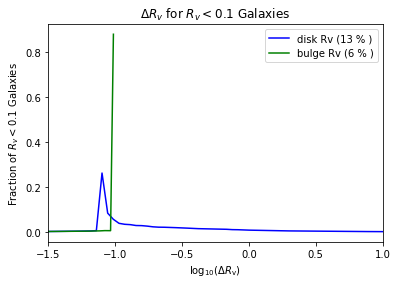

In [120]:
fig, ax = plt.subplots(1, 1)
Rv_new = 0.1
Av_new = 1.0
masks = [mask_Rvd1, mask_Rvb1]
quantities = ['disk_Rv', 'bulge_Rv']
colors = ['blue', 'green']
for msk, q, c in zip(masks, quantities, colors):
    total = np.count_nonzero(msk)/float(len(mock['bulge_V_rest']))
    print(q, np.count_nonzero(msk), np.count_nonzero(msk)/float(len(mock['bulge_V_rest'])))
    label = re.sub('_', ' ',q) + ' ({:.0f} % )'.format(100.*total)
    if np.count_nonzero(msk) > 0:
        print('min/max =', np.min(Rv_new - mock[q][msk]), np.max(Rv_new - mock[q][msk]))
        N, bins = np.histogram(np.log10(Rv_new - mock[q][msk]), bins=200)
        bin_cent = 0.5*(bins[:-1] + bins[1:])
        __=ax.plot(bin_cent, N/float(np.count_nonzero(msk)), color=c, label=label)
    else:
        __=ax.plot(bin_cent, np.zeros(len(bin_cent)), color=c, label=label)

leg = ax.legend()
xlim = ax.set_xlim(-1.5, 1.)
xlabel = ax.set_xlabel(r'${\log_{10}(\Delta R_{\rm v})}$')
cut = '$R_v < {:.1f}$ Galaxies'.format(Rv_new)
ylabel = ax.set_ylabel('Fraction of {}'.format(cut))
title = ax.set_title(r'$\Delta R_v$ for ' + cut)
figname = 'rv_shift.png'
fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')       


disk_Av 411049 0.012883465425872518
411048
min/max = 1.0 99.5747
bulge_Av 138992 0.004356411587117043
138992
min/max = 1.00001 5.04198


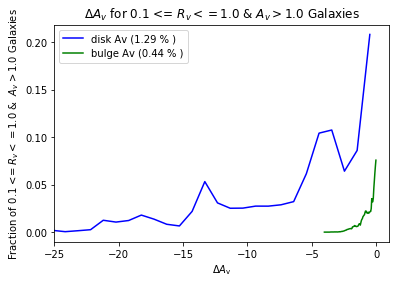

In [158]:
fig, ax_array = plt.subplots(1, 1)
Av_new = 1.0
Rv_new = 0.1
Rv_lim = 1.0
mask_Avd3 = mask_Avd2 & mask_Rvd1
mask_Avb3 = mask_Avb2 & mask_Rvb1
mask_Avd4 = mask_Avd2 & mask_Rvd2
mask_Avb4 = mask_Avb2 & mask_Rvb2
quantities = ['disk_Av', 'bulge_Av']
cut1 = '$R_v < {:.1f}$'.format(Rv_new)
cut0 = '{:.1f} <= $R_v <= {:.1f}$ & '.format(Rv_new, Rv_lim)
for ax, masks in zip([ax_array], [[mask_Avd4, mask_Avb4]]):
    colors = ['blue', 'green']
    for msk, q, c in zip(masks, quantities, colors):
        total = np.count_nonzero(msk)/float(len(mock['bulge_V_rest']))
        print(q, np.count_nonzero(msk), np.count_nonzero(msk)/float(len(mock['bulge_V_rest'])))
        print(np.count_nonzero(np.isfinite(mock[q][msk])))
        label = re.sub('_', ' ',q) + ' ({:.2f} % )'.format(100.*total)
        if np.count_nonzero(msk) > 0:
            maskf = np.isfinite(mock[q]) & msk
            if np.count_nonzero(maskf) > 0:
                print('min/max =', np.min(mock[q][maskf]), np.max(mock[q][maskf]))
                N, bins = np.histogram(Av_new - mock[q][maskf], bins=100)
                bin_cent = 0.5*(bins[:-1] + bins[1:])
                #print(N, N/float(np.count_nonzero(maskf)), np.sum(N))
                __=ax.plot(bin_cent, N/float(np.count_nonzero(maskf)), color=c, label=label)

    leg = ax.legend()
    xlim = ax.set_xlim(-25., 1.0)
    xlabel = ax.set_xlabel(r'$\Delta A_{\rm v}$')
    cut = '$A_v > {:.1f}$ Galaxies'.format(Av_new)
    ylabel = ax.set_ylabel('Fraction of {} {}'.format(cut0, cut))
    title = ax.set_title(r'$\Delta A_v$ for ' + cut0 + cut)
    figname = 'av_shift2.png'
    fig.savefig(figname, bbox_extra_artists=[xlabel, ylabel])       
